## Neural Network Project - Gesture Recognition 

In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
import cv2
from cv2 import imread
import matplotlib.pyplot as plt
#from scipy.misc import imread, imresize
import datetime
import os
from tensorflow.keras.utils import img_to_array, array_to_img, load_img

from keras.models import Model, load_model, Sequential
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Flatten
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv3D
from keras.layers.pooling import MaxPooling3D, GlobalMaxPool3D
# from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from keras import optimizers
from tensorflow.keras.utils import img_to_array, array_to_img, load_img
from keras.layers import concatenate, add
from keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)
#tf.device('/cpu:0')

In this block, you read the folder names for training and validation. You also set the batch_size here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
# reusable functions
def resize(input_image,threshold=False):
   # gray = cv2.cvtColor(input_image,cv2.COLOR_BGR2GRAY)
   resized = cv2.resize(input_image, dsize=(120, 120), interpolation=cv2.INTER_CUBIC)
   input_image = img_to_array(resized)
   return input_image

def normalize_image(input_image):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   return input_image

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    #axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    #axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [4]:
train_doc = np.random.permutation(open(r'C:\Users\I552991\Downloads\Project_data\train.csv').readlines())
val_doc = np.random.permutation(open(r'C:\Users\I552991\Downloads\Project_data\val.csv').readlines())
batch_size = 30 #experiment with the batch size
# print(len(train_doc))
global number_of_sequences
number_of_sequences = 30 #len(train_doc)
# batch size should be large enough to include all the train data.
# GPU might not be able to handle all the train data, in that case we will have to reduce the batch data.
# assignment - 663 folder approx 1.5 GB

### Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with img_idx, y,z and normalization such that you get high accuracy.

In [5]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0, 30)) #create a list of image numbers you want to use for a particular video
    x = len(img_idx)
    y = 120
    z = 120
    # 30 images per folder, might not want to use all of them.
    # sampling 15-20 images should be good.
    # 30 might lead to memory issues
    while True:
        t = np.random.permutation(folder_list)
        num_batches = number_of_sequences//batch_size # calculate the number of batches
        print(num_batches)
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize(image)
                    image = normalize_image(image)
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])#normalise and feed in the image
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches
        if (number_of_sequences != batch_size*num_batches):
            print('fetching missed out folders')
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = number_of_sequences - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = resize(image)
                    image = normalize_image(image)
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = r'C:\Users\I552991\Downloads\Project_data\train'
val_path = r'C:\Users\I552991\Downloads\Project_data\val'
num_train_sequences = 10 #len(train_doc) # modify this to small number while building
print('# training sequences =', num_train_sequences)
num_val_sequences = 10 #len(val_doc) # modify this to small number while building
print('# validation sequences =', num_val_sequences)
num_epochs = 5 # choose the number of epochs # modify this to small number while building
print ('# epochs =', num_epochs)

# training sequences = 10
# validation sequences = 10
# epochs = 5


## Model 1

Here you make the model using different functionalities that Keras provides. Remember to use Conv3D and MaxPooling3D and not Conv2D and Maxpooling2D for a 3D convolution model. You would want to use TimeDistributed while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Conv 3D Model with 30 frames per video (32, 64, 128, 256 filters conv 3D layers + 1000 dense layer + 500 dense layer + image size 120 by 120)

In [7]:
model1 = Sequential()

model1.add(Conv3D(32, #number of filters
                 kernel_size=(3,3,3),
                 input_shape=(30, 120, 120, 3),
                 padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))

model1.add(MaxPooling3D(pool_size=(2,2,2)))

model1.add(Conv3D(64, #Number of filters,
                 kernel_size=(3,3,3),
                 padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))

model1.add(MaxPooling3D(pool_size=(2,2,2)))

model1.add(Conv3D(128, #Number of filters
                 kernel_size=(1,3,3),
                 padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))

model1.add(MaxPooling3D(pool_size=(2,2,2)))

model1.add(Conv3D(256, #Number pf filters
                 kernel_size=(1,3,3),
                 padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))

model1.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model1.add(Flatten())

model1.add(Dense(1000, activation='relu'))
model1.add(Dropout(0.25))

model1.add(Dense(500, activation='relu'))
model1.add(Dropout(0.25))

#softmax layer
model1.add(Dense(5, activation='softmax'))


Now that you have written the model, the next step is to compile the model. When you print the summary of the model, you'll see the total number of parameters you have to train.

In [8]:
optimiser = optimizers.Adam(lr=0.001)#write your optimizer
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy','accuracy'])
print (model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 32)  2624      
                                                                 
 batch_normalization (BatchN  (None, 30, 120, 120, 32)  128      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 120, 120, 32)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 60, 60, 32)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 60, 60, 64)    55360     
                                                                 
 batch_normalization_1 (Batc  (None, 15, 60, 60, 64)   2

C:\Users\I552991\Anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Trainable params: 13,475,973
Non-trainable params: 960
_________________________________________________________________
None


Let us create the train_generator and the val_generator which will be used in .fit_generator.

In [9]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [10]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.

In [11]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [12]:
history = model1.fit_generator(train_generator, steps_per_epoch=1, epochs=5, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0) 
# steps_per_epoch=steps_per_epoch, epochs=num_ep

C:\Users\I552991\AppData\Local\Temp\ipykernel_24564\3213003889.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model1.fit_generator(train_generator, steps_per_epoch=1, epochs=5, verbose=1,


Source path =  C:\Users\I552991\Downloads\Project_data\train ; batch size = 30
1
Epoch 1/5
1
1/1 [==============================] - ETA: 0s - loss: 2.3386 - categorical_accuracy: 0.1667 - accuracy: 0.1667Source path =  C:\Users\I552991\Downloads\Project_data\val ; batch size = 30
1
1

Epoch 1: saving model to model_init_2023-06-1819_56_09.245023\model-00001-2.33855-0.16667-2.42603-0.23333.h5
1/1 [==============================] - 229s 229s/step - loss: 2.3386 - categorical_accuracy: 0.1667 - accuracy: 0.1667 - val_loss: 2.4260 - val_categorical_accuracy: 0.2333 - val_accuracy: 0.2333 - lr: 0.0010
Epoch 2/5
1
1/1 [==============================] - ETA: 0s - loss: 36.6595 - categorical_accuracy: 0.3333 - accuracy: 0.33331
1

Epoch 2: saving model to model_init_2023-06-1819_56_09.245023\model-00002-36.65948-0.33333-2.06084-0.30000.h5
1/1 [==============================] - 429s 429s/step - loss: 36.6595 - categorical_accuracy: 0.3333 - accuracy: 0.3333 - val_loss: 2.0608 - val_categorical_

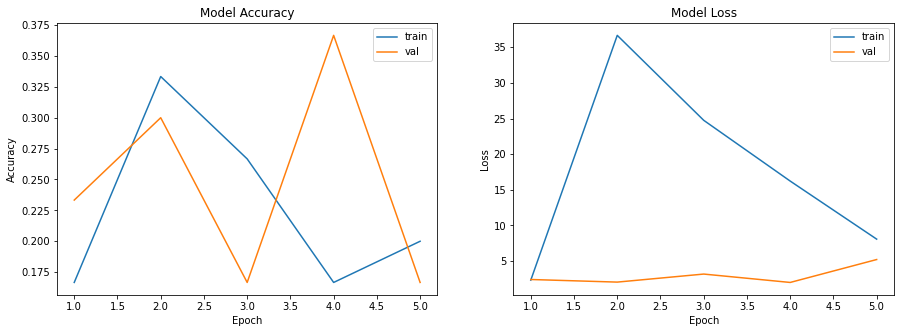

In [13]:
plot_model_history(history)

## Model 2

### Conv 3D Model with 20 frames per video (32, 64, 128, 256 filters conv 3D layers + 1000 dense layer + 500 dense layer + image size 120 by 120)

In [14]:
model2 = Sequential()

model2.add(Conv3D(32, #number of filters
                 kernel_size=(3,3,3),
                 input_shape=(20, 120, 120, 3),
                 padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))

model2.add(MaxPooling3D(pool_size=(2,2,2)))

model2.add(Conv3D(64, #Number of filters,
                 kernel_size=(3,3,3),
                 padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))

model2.add(MaxPooling3D(pool_size=(2,2,2)))

model2.add(Conv3D(128, #Number of filters
                 kernel_size=(1,3,3),
                 padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))

model2.add(MaxPooling3D(pool_size=(2,2,2)))

model2.add(Conv3D(256, #Number pf filters
                 kernel_size=(1,3,3),
                 padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))

model2.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model2.add(Flatten())

model2.add(Dense(1000, activation='relu'))
model2.add(Dropout(0.25))

model2.add(Dense(500, activation='relu'))
model2.add(Dropout(0.25))

#softmax layer
model2.add(Dense(5, activation='softmax'))

In [17]:
optimiser = optimizers.Adam(lr=0.001)#write your optimizer
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy','accuracy'])
print (model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 120, 120, 32)  2624      
                                                                 
 batch_normalization_4 (Batc  (None, 20, 120, 120, 32)  128      
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 20, 120, 120, 32)  0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 60, 60, 32)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 60, 60, 64)    55360     
                                                                 
 batch_normalization_5 (Batc  (None, 10, 60, 60, 64)  

In [18]:
history = model2.fit_generator(train_generator, steps_per_epoch=1, epochs=5, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0) 
# steps_per_epoch=steps_per_epoch, epochs=num_ep

C:\Users\I552991\AppData\Local\Temp\ipykernel_24564\1550084936.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model2.fit_generator(train_generator, steps_per_epoch=1, epochs=5, verbose=1,


1
Epoch 1/5
1
1/1 [==============================] - ETA: 0s - loss: 3.3136 - categorical_accuracy: 0.1333 - accuracy: 0.13331
1

Epoch 1: saving model to model_init_2023-06-1819_56_09.245023\model-00001-3.31359-0.13333-3.03821-0.20000.h5
1/1 [==============================] - 216s 216s/step - loss: 3.3136 - categorical_accuracy: 0.1333 - accuracy: 0.1333 - val_loss: 3.0382 - val_categorical_accuracy: 0.2000 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 2/5
1
1/1 [==============================] - ETA: 0s - loss: 58.4990 - categorical_accuracy: 0.2000 - accuracy: 0.20001
1

Epoch 2: saving model to model_init_2023-06-1819_56_09.245023\model-00002-58.49903-0.20000-3.77277-0.26667.h5
1/1 [==============================] - 220s 220s/step - loss: 58.4990 - categorical_accuracy: 0.2000 - accuracy: 0.2000 - val_loss: 3.7728 - val_categorical_accuracy: 0.2667 - val_accuracy: 0.2667 - lr: 0.0010
Epoch 3/5
1
1/1 [==============================] - ETA: 0s - loss: 40.7168 - categorical_accuracy: 0.23

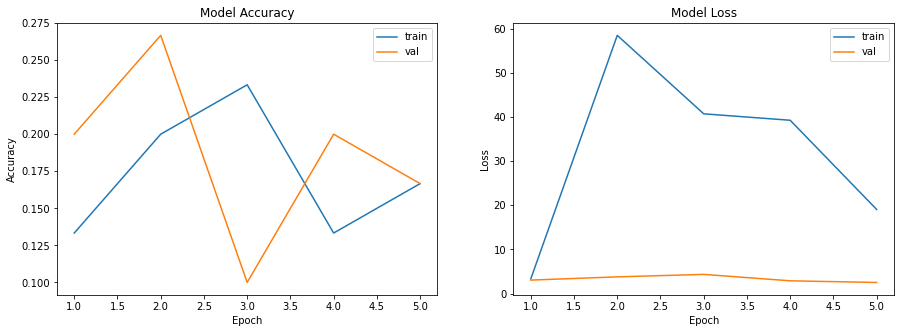

In [19]:
plot_model_history(history)

## Model 3 

### Conv 3D Model with 30 frames per video (32, 64, 128, 256 filters conv 3D layers + 1000 dense layer + 500 dense layer + image size 160 by 160)

In [23]:
model3 = Sequential()

model3.add(Conv3D(32, #number of filters
                 kernel_size=(3,3,3),
                 input_shape=(30, 160, 160, 3),
                 padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))

model3.add(MaxPooling3D(pool_size=(2,2,2)))

model3.add(Conv3D(64, #Number of filters,
                 kernel_size=(3,3,3),
                 padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))

model3.add(MaxPooling3D(pool_size=(2,2,2)))

model3.add(Conv3D(128, #Number of filters
                 kernel_size=(1,3,3),
                 padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))

model3.add(MaxPooling3D(pool_size=(2,2,2)))

model3.add(Conv3D(256, #Number pf filters
                 kernel_size=(1,3,3),
                 padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))

model3.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model3.add(Flatten())

model3.add(Dense(1000, activation='relu'))
model3.add(Dropout(0.25))

model3.add(Dense(500, activation='relu'))
model3.add(Dropout(0.25))

#softmax layer
model3.add(Dense(5, activation='softmax'))

In [24]:
optimiser = optimizers.Adam(lr=0.001)#write your optimizer
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy','accuracy'])
print (model3.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 30, 160, 160, 32)  2624      
                                                                 
 batch_normalization_12 (Bat  (None, 30, 160, 160, 32)  128      
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 30, 160, 160, 32)  0         
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 15, 80, 80, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 15, 80, 80, 64)    55360     
                                                                 
 batch_normalization_13 (Bat  (None, 15, 80, 80, 64)  

In [25]:
history = model3.fit_generator(train_generator, steps_per_epoch=1, epochs=5, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0) 
# steps_per_epoch=steps_per_epoch, epochs=num_ep

C:\Users\I552991\AppData\Local\Temp\ipykernel_24564\2587709968.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model3.fit_generator(train_generator, steps_per_epoch=1, epochs=5, verbose=1,


1
Epoch 1/5
1


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_3/dense_9/Relu' defined at (most recent call last):
    File "C:\Users\I552991\Anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\I552991\Anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\I552991\Anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\I552991\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\I552991\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\I552991\Anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\I552991\Anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\I552991\Anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\I552991\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\I552991\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\I552991\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "C:\Users\I552991\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\I552991\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\I552991\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\I552991\AppData\Local\Temp\ipykernel_24564\2587709968.py", line 1, in <cell line: 1>
      history = model3.fit_generator(train_generator, steps_per_epoch=1, epochs=5, verbose=1,
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\engine\training.py", line 2636, in fit_generator
      return self.fit(
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\engine\training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\engine\training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\engine\training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\engine\training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\engine\training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\engine\training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\engine\sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\layers\core\dense.py", line 255, in call
      outputs = self.activation(outputs)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\backend.py", line 5396, in relu
      x = tf.nn.relu(x)
Node: 'sequential_3/dense_9/Relu'
Matrix size-incompatible: In[0]: [30,12544], In[1]: [25600,1000]
	 [[{{node sequential_3/dense_9/Relu}}]] [Op:__inference_train_function_482311]

In [ ]:
plot_model_history(history)

## Model 4 

### Conv 3D Model with 20 frames per video (32, 64, 128, 256 filters conv 3D layers + 1000 dense layer + 500 dense layer + image size 160 by 160)

In [26]:
model4 = Sequential()

model4.add(Conv3D(32, #number of filters
                 kernel_size=(3,3,3),
                 input_shape=(20, 160, 160, 3),
                 padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))

model4.add(MaxPooling3D(pool_size=(2,2,2)))

model4.add(Conv3D(64, #Number of filters,
                 kernel_size=(3,3,3),
                 padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))

model4.add(MaxPooling3D(pool_size=(2,2,2)))

model4.add(Conv3D(128, #Number of filters
                 kernel_size=(1,3,3),
                 padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))

model4.add(MaxPooling3D(pool_size=(2,2,2)))

model4.add(Conv3D(256, #Number pf filters
                 kernel_size=(1,3,3),
                 padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))

model4.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model4.add(Flatten())

model4.add(Dense(1000, activation='relu'))
model4.add(Dropout(0.25))

model4.add(Dense(500, activation='relu'))
model4.add(Dropout(0.25))

#softmax layer
model4.add(Dense(5, activation='softmax'))

In [27]:
optimiser = optimizers.Adam(lr=0.001)#write your optimizer
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy','accuracy'])
print (model4.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 20, 160, 160, 32)  2624      
                                                                 
 batch_normalization_16 (Bat  (None, 20, 160, 160, 32)  128      
 chNormalization)                                                
                                                                 
 activation_16 (Activation)  (None, 20, 160, 160, 32)  0         
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 10, 80, 80, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 10, 80, 80, 64)    55360     
                                                                 
 batch_normalization_17 (Bat  (None, 10, 80, 80, 64)  

In [28]:
history = model4.fit_generator(train_generator, steps_per_epoch=1, epochs=5, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0) 
# steps_per_epoch=steps_per_epoch, epochs=num_ep

C:\Users\I552991\AppData\Local\Temp\ipykernel_24564\3704280449.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model4.fit_generator(train_generator, steps_per_epoch=1, epochs=5, verbose=1,


1
Epoch 1/5
1


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_4/dense_12/Relu' defined at (most recent call last):
    File "C:\Users\I552991\Anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\I552991\Anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\I552991\Anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\I552991\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\I552991\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\I552991\Anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\I552991\Anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\I552991\Anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\I552991\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\I552991\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\I552991\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "C:\Users\I552991\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\I552991\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\I552991\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\I552991\AppData\Local\Temp\ipykernel_24564\3704280449.py", line 1, in <cell line: 1>
      history = model4.fit_generator(train_generator, steps_per_epoch=1, epochs=5, verbose=1,
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\engine\training.py", line 2636, in fit_generator
      return self.fit(
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\engine\training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\engine\training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\engine\training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\engine\training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\engine\training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\engine\training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\engine\sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\layers\core\dense.py", line 255, in call
      outputs = self.activation(outputs)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\backend.py", line 5396, in relu
      x = tf.nn.relu(x)
Node: 'sequential_4/dense_12/Relu'
Matrix size-incompatible: In[0]: [30,12544], In[1]: [25600,1000]
	 [[{{node sequential_4/dense_12/Relu}}]] [Op:__inference_train_function_511105]

In [ ]:
plot_model_history(history)

## Model 5 

### Conv 3D Model with 30 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)

In [29]:
model5 = Sequential()

model5.add(Conv3D(16, #number of filters
                 kernel_size=(3,3,3),
                 input_shape=(30, 120, 120, 3),
                 padding='same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))

model5.add(MaxPooling3D(pool_size=(2,2,2)))

model5.add(Conv3D(32, #Number of filters,
                 kernel_size=(3,3,3),
                 padding='same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))

model5.add(MaxPooling3D(pool_size=(2,2,2)))

model5.add(Conv3D(64, #Number of filters
                 kernel_size=(1,3,3),
                 padding='same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))

model5.add(MaxPooling3D(pool_size=(2,2,2)))

model5.add(Conv3D(128, #Number pf filters
                 kernel_size=(1,3,3),
                 padding='same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))

model5.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model5.add(Flatten())

model5.add(Dense(256, activation='relu'))
model5.add(Dropout(0.25))

model5.add(Dense(128, activation='relu'))
model5.add(Dropout(0.25))

#softmax layer
model5.add(Dense(5, activation='softmax'))

In [30]:
optimiser = optimizers.Adam(lr=0.001)#write your optimizer
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy','accuracy'])
print (model5.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 batch_normalization_20 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 activation_20 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 15, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 15, 60, 60, 32)    13856     
                                                                 
 batch_normalization_21 (Bat  (None, 15, 60, 60, 32)  

In [31]:
history = model5.fit_generator(train_generator, steps_per_epoch=1, epochs=5, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0) 
# steps_per_epoch=steps_per_epoch, epochs=num_ep

C:\Users\I552991\AppData\Local\Temp\ipykernel_24564\3386939733.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model5.fit_generator(train_generator, steps_per_epoch=1, epochs=5, verbose=1,


1
Epoch 1/5
1
1/1 [==============================] - ETA: 0s - loss: 2.7000 - categorical_accuracy: 0.1000 - accuracy: 0.10001
1

Epoch 1: saving model to model_init_2023-06-1819_56_09.245023\model-00001-2.69996-0.10000-1.60858-0.13333.h5
1/1 [==============================] - 74s 74s/step - loss: 2.7000 - categorical_accuracy: 0.1000 - accuracy: 0.1000 - val_loss: 1.6086 - val_categorical_accuracy: 0.1333 - val_accuracy: 0.1333 - lr: 0.0010
Epoch 2/5
1
1/1 [==============================] - ETA: 0s - loss: 6.3751 - categorical_accuracy: 0.1667 - accuracy: 0.16671
1

Epoch 2: saving model to model_init_2023-06-1819_56_09.245023\model-00002-6.37515-0.16667-1.62880-0.20000.h5
1/1 [==============================] - 72s 72s/step - loss: 6.3751 - categorical_accuracy: 0.1667 - accuracy: 0.1667 - val_loss: 1.6288 - val_categorical_accuracy: 0.2000 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 3/5
1
1/1 [==============================] - ETA: 0s - loss: 5.4191 - categorical_accuracy: 0.3667 - acc

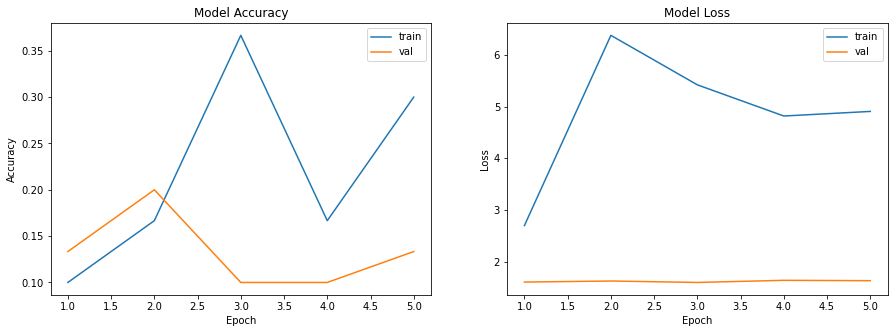

In [32]:
plot_model_history(history)

## Model 6 

### Conv 3D Model with 30 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 160 by 160)

In [33]:
model6 = Sequential()

model6.add(Conv3D(16, #number of filters
                 kernel_size=(3,3,3),
                 input_shape=(30, 160, 160, 3),
                 padding='same'))
model6.add(BatchNormalization())
model6.add(Activation('relu'))

model6.add(MaxPooling3D(pool_size=(2,2,2)))

model6.add(Conv3D(32, #Number of filters,
                 kernel_size=(3,3,3),
                 padding='same'))
model6.add(BatchNormalization())
model6.add(Activation('relu'))

model6.add(MaxPooling3D(pool_size=(2,2,2)))

model6.add(Conv3D(64, #Number of filters
                 kernel_size=(1,3,3),
                 padding='same'))
model6.add(BatchNormalization())
model6.add(Activation('relu'))

model6.add(MaxPooling3D(pool_size=(2,2,2)))

model6.add(Conv3D(128, #Number pf filters
                 kernel_size=(1,3,3),
                 padding='same'))
model6.add(BatchNormalization())
model6.add(Activation('relu'))

model6.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model6.add(Flatten())

model6.add(Dense(256, activation='relu'))
model6.add(Dropout(0.25))

model6.add(Dense(128, activation='relu'))
model6.add(Dropout(0.25))

#softmax layer
model6.add(Dense(5, activation='softmax'))

In [34]:
optimiser = optimizers.Adam(lr=0.001)#write your optimizer
model6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy','accuracy'])
print (model6.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 30, 160, 160, 16)  1312      
                                                                 
 batch_normalization_24 (Bat  (None, 30, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 activation_24 (Activation)  (None, 30, 160, 160, 16)  0         
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 15, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 15, 80, 80, 32)    13856     
                                                                 
 batch_normalization_25 (Bat  (None, 15, 80, 80, 32)  

In [35]:
history = model6.fit_generator(train_generator, steps_per_epoch=1, epochs=5, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0) 
# steps_per_epoch=steps_per_epoch, epochs=num_ep

C:\Users\I552991\AppData\Local\Temp\ipykernel_24564\3950262336.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model6.fit_generator(train_generator, steps_per_epoch=1, epochs=5, verbose=1,


1
Epoch 1/5
1


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_6/dense_18/Relu' defined at (most recent call last):
    File "C:\Users\I552991\Anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\I552991\Anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\I552991\Anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\I552991\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\I552991\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\I552991\Anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\I552991\Anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\I552991\Anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\I552991\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\I552991\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\I552991\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "C:\Users\I552991\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\I552991\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\I552991\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\I552991\AppData\Local\Temp\ipykernel_24564\3950262336.py", line 1, in <cell line: 1>
      history = model6.fit_generator(train_generator, steps_per_epoch=1, epochs=5, verbose=1,
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\engine\training.py", line 2636, in fit_generator
      return self.fit(
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\engine\training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\engine\training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\engine\training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\engine\training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\engine\training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\engine\training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\engine\sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\layers\core\dense.py", line 255, in call
      outputs = self.activation(outputs)
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "C:\Users\I552991\Anaconda3\lib\site-packages\keras\backend.py", line 5396, in relu
      x = tf.nn.relu(x)
Node: 'sequential_6/dense_18/Relu'
Matrix size-incompatible: In[0]: [30,6272], In[1]: [12800,256]
	 [[{{node sequential_6/dense_18/Relu}}]] [Op:__inference_train_function_759005]

In [ ]:
plot_model_history(history)

## Model 7 

### Conv 3D Model with 20 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)

In [36]:
model7 = Sequential()

model7.add(Conv3D(16, #number of filters
                 kernel_size=(3,3,3),
                 input_shape=(20, 120, 120, 3),
                 padding='same'))
model7.add(BatchNormalization())
model7.add(Activation('relu'))

model7.add(MaxPooling3D(pool_size=(2,2,2)))

model7.add(Conv3D(32, #Number of filters,
                 kernel_size=(3,3,3),
                 padding='same'))
model7.add(BatchNormalization())
model7.add(Activation('relu'))

model7.add(MaxPooling3D(pool_size=(2,2,2)))

model7.add(Conv3D(64, #Number of filters
                 kernel_size=(1,3,3),
                 padding='same'))
model7.add(BatchNormalization())
model7.add(Activation('relu'))

model7.add(MaxPooling3D(pool_size=(2,2,2)))

model7.add(Conv3D(128, #Number pf filters
                 kernel_size=(1,3,3),
                 padding='same'))
model7.add(BatchNormalization())
model7.add(Activation('relu'))

model7.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model7.add(Flatten())

model7.add(Dense(256, activation='relu'))
model7.add(Dropout(0.25))

model7.add(Dense(128, activation='relu'))
model7.add(Dropout(0.25))

#softmax layer
model7.add(Dense(5, activation='softmax'))

In [37]:
optimiser = optimizers.Adam(lr=0.001)#write your optimizer
model7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy','accuracy'])
print (model7.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 20, 120, 120, 16)  1312      
                                                                 
 batch_normalization_28 (Bat  (None, 20, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 activation_28 (Activation)  (None, 20, 120, 120, 16)  0         
                                                                 
 max_pooling3d_28 (MaxPoolin  (None, 10, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_29 (Conv3D)          (None, 10, 60, 60, 32)    13856     
                                                                 
 batch_normalization_29 (Bat  (None, 10, 60, 60, 32)  

In [38]:
history = model7.fit_generator(train_generator, steps_per_epoch=1, epochs=5, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0) 
# steps_per_epoch=steps_per_epoch, epochs=num_ep

C:\Users\I552991\AppData\Local\Temp\ipykernel_24564\501070825.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model7.fit_generator(train_generator, steps_per_epoch=1, epochs=5, verbose=1,


1
Epoch 1/5
1
1/1 [==============================] - ETA: 0s - loss: 2.7156 - categorical_accuracy: 0.1667 - accuracy: 0.16671
1

Epoch 1: saving model to model_init_2023-06-1819_56_09.245023\model-00001-2.71560-0.16667-1.66607-0.23333.h5
1/1 [==============================] - 72s 72s/step - loss: 2.7156 - categorical_accuracy: 0.1667 - accuracy: 0.1667 - val_loss: 1.6661 - val_categorical_accuracy: 0.2333 - val_accuracy: 0.2333 - lr: 0.0010
Epoch 2/5
1
1/1 [==============================] - ETA: 0s - loss: 5.8875 - categorical_accuracy: 0.3000 - accuracy: 0.30001
1

Epoch 2: saving model to model_init_2023-06-1819_56_09.245023\model-00002-5.88750-0.30000-1.59990-0.23333.h5
1/1 [==============================] - 77s 77s/step - loss: 5.8875 - categorical_accuracy: 0.3000 - accuracy: 0.3000 - val_loss: 1.5999 - val_categorical_accuracy: 0.2333 - val_accuracy: 0.2333 - lr: 0.0010
Epoch 3/5
1
1/1 [==============================] - ETA: 0s - loss: 6.8004 - categorical_accuracy: 0.1333 - acc

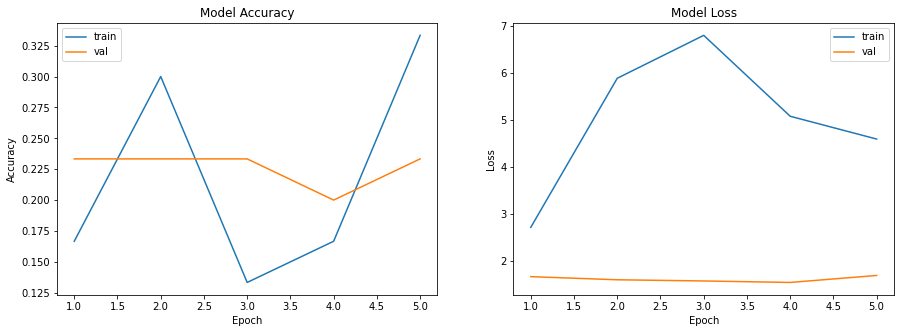

In [39]:
plot_model_history(history)